# Short-List Promising Models
___

 - If the data is huge, you may want to sample smaller training sets so you can train many different models in a reasonable time (be aware that this penalizes complex models such as large neural nets or Random Forests).
 - Once again, try to automate these steps as much as possible.
 - Train many quick-and-dirty models from different categories (e.g., linear, naive Bayes, SVM, Random Forest, neural net, etc.) using standard parameters.
 - Measure and compare their performance.
 - For each model, use N-fold cross-validation and compute the mean and standard deviation of the performance measure on the N folds.
 - Analyze the most significant variables for each algorithm.
 - Analyze the types of errors the models make.
 - What data would a human have used to avoid these errors?
 - Perform a quick round of feature selection and engineering.
 - Perform one or two more quick iterations of the five previous steps.
 - Shordist the top three to five most promising models, preferring models that make different types of errors.

---

In [114]:
# Import Libraries
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split


from keras.layers import Add, Activation, Lambda
from keras.models import Model
from keras.layers import Input, Reshape, Dot
from keras.layers.embeddings import Embedding
from tensorflow.keras.optimizers import Adam

# from keras.optimizers import Adam
from keras.regularizers import l2

import math


# Set printing in non scientific notation
np.set_printoptions(suppress=True)

# Change label colors of matplotlib
import matplotlib as mpl
mpl.rcParams['figure.facecolor'] = 'white'

Data

In [115]:
combined_business_data = pd.read_pickle("combined_business_data.pkl")
combined_business_data.head(2)

,user_id,business_id,stars,date,name,address,user,business
0,nOTl4aPC4tKHK35T3bNauQ,xVEtGucSRLk5pxxN0t4i6g,5.0,2012-08-23,"""Eiffel Tower""","""3655 Las Vegas Blvd S""",4189,1920
1,l0-VQ8nA_oijpKlRB7dkow,xVEtGucSRLk5pxxN0t4i6g,4.0,2010-02-11,"""Eiffel Tower""","""3655 Las Vegas Blvd S""",3989,1920


In [116]:
# Store counts of distinct users and restaurants into variables
n_users = combined_business_data["user"].nunique()
n_rests = combined_business_data["business"].nunique()

# Store min and max stars into a variable
min_rating = min(combined_business_data["stars"])
max_rating = max(combined_business_data["stars"])

print(n_users, n_rests, min_rating, max_rating)

5186 2004 1.0 5.0


In [117]:
# Store inputs into variabe X; store Output into variable y
X = combined_business_data[["user", "business"]].values
y = combined_business_data["stars"].values

print(X.shape, y.shape)

(11591, 2) (11591,)


Split

In [118]:
# Split data into Training and Validation set
X_train_keras, X_val_keras, y_train_keras, y_val_keras = train_test_split(
    X,
    y,
    test_size=0.2,
    random_state=42,
)

print(X_train_keras.shape, X_val_keras.shape, y_train_keras.shape, y_val_keras.shape)

(9272, 2) (2319, 2) (9272,) (2319,)


In [119]:
# Storing Users and Restaurant into its own array. They will be input separately into the Keras Model
X_train_array = [X_train_keras[:, 0], X_train_keras[:, 1]]
X_val_array = [X_val_keras[:, 0], X_val_keras[:, 1]]

In [120]:
X_train_array

[array([3527, 3494,  763, ..., 4744, 1615, 2416]),
 array([ 166, 1511, 1972, ...,  480,  870,  918])]

In [121]:
X_val_array

[array([2068, 1672, 1196, ..., 4855, 2335, 4817]),
 array([ 118, 1293,  235, ...,  291,  974,  788])]

Choose number of dimensions in embedding space

In [122]:
# Variable that stores number of embedding dimension. Will be tuned as hyperparameter later.
n_embedding_dim = 2

Model

In [123]:
class EmbeddingLayer:
    '''
    Class to create main section of the model, creating embedding layer followed by the reshape layer.
    '''
    def __init__(self, n_items, n_embedding_dim):
        # ^ vocabulary size, number of categories, or here,
        # ^ number of distinct users or number of distinct restaurants
        self.n_items = n_items

        # ^ encode into how many dimensions?
        # ^ each item(user/restaurant) will be represented as a vector of size n_embedding_dim
        self.n_embedding_dim = n_embedding_dim

    def __call__(self, x):
        x = Embedding(
            input_dim = self.n_items, # number of users/restaurants in a training set
            output_dim = self.n_embedding_dim, # how many dimensions should embedding space contain
            embeddings_initializer="he_normal", # initializer for initial parameter values at the beggining of training
            embeddings_regularizer=l2(1e-6), # regularzation to reduce overfitting
        )(x)
        x = Reshape((self.n_embedding_dim,))(x)

        return x


def Recommender(n_users, n_rests, n_embedding_dim, min_rating, max_rating):
    user = Input(shape=(1,))
    u = EmbeddingLayer(n_users, n_embedding_dim)(user)

    restaurant = Input(shape=(1,))
    m = EmbeddingLayer(n_rests, n_embedding_dim)(restaurant)

    x = Dot(axes=1)([u, m]) # Dot product between vector of user and vector of restaurant
    x = Activation("sigmoid")(x)
    x = Lambda(lambda x: x * (max_rating - min_rating) + min_rating)(x) # Scaling

    model = Model(inputs=[user, restaurant], outputs=x) # Creating the model and specifying input and output
    opt = Adam(learning_rate=0.001) # Optimizer algorithm and its learning rate
    model.compile(loss="mean_squared_error", optimizer=opt) # compiling model and specifying loss function

    return model

In [124]:
keras_model = Recommender(n_users, n_rests, n_embedding_dim, min_rating, max_rating)
keras_model.summary()

Model: "model_7"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_15 (InputLayer)           [(None, 1)]          0                                            
__________________________________________________________________________________________________
input_16 (InputLayer)           [(None, 1)]          0                                            
__________________________________________________________________________________________________
embedding_23 (Embedding)        (None, 1, 2)         10372       input_15[0][0]                   
__________________________________________________________________________________________________
embedding_24 (Embedding)        (None, 1, 2)         4008        input_16[0][0]                   
____________________________________________________________________________________________

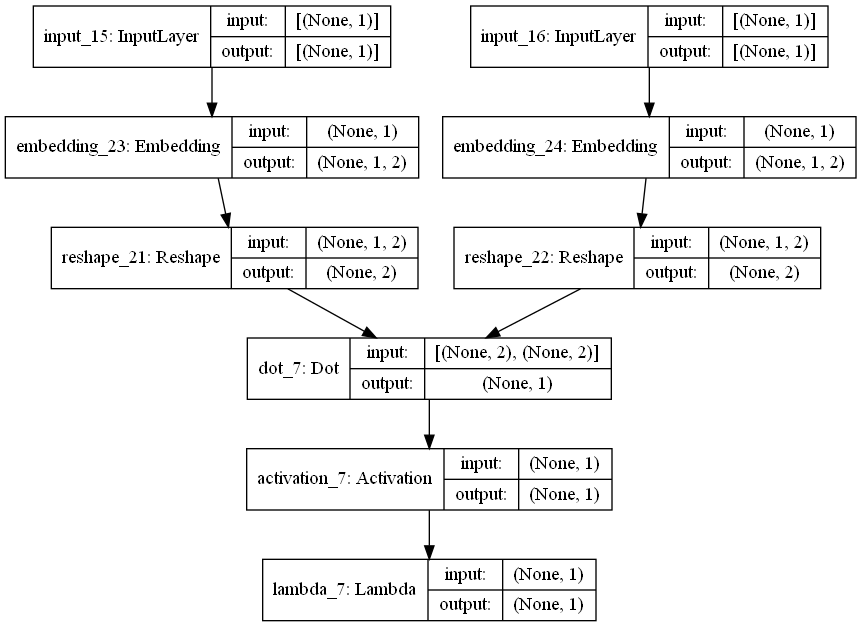

In [125]:
# Plot Model
from keras.utils.vis_utils import plot_model

plot_model(keras_model, show_shapes=True)


 ## Algorithm DESCRIPTION (simplified)
- "None" in the picture stays for the size of the batch, Lets say batch is 1
    -   On first iteration Input is some user number, say 5; and also some restaurant number, say 10
    -   User number 5 is changed by Embedding layer to a vector of size 2 (after reshaping); e.g. (1,2);
        -   (Why reshaping: Embedding layer outputs a matrix of one row and 2 columns; but we want a vector of size 2)
        -   What number will this vector contain will be trained by neural network to achieve best performance (lowest loss function)
    -   Restaurant number 10 is changed say to a vector (5,7)
<br>
<br>
    -   Vector of size 2 is DOT MULTIPLIED by vector of size 2; e.g. (1,2) * (5,7) = 1*2 + 2*7 = 2 + 14 = 16
    -   16 is input to the sigmoid function which outputs a number between 0 and 1 (see example below), specifically sigmoid(16) = 0.9999998874648379
    -   0.9999998874648379 is min max scaled to return 4.999999549859352, which is the prediction that this user 5 gave to the restaurant 10
<br>
<br>
    -   this prediction is compared to the actual rating that this user 5 gave to the restaurant 10, say actually he rated it 4
    -   error now is 4.999999549859352 - 4 = 0.999999549859352 (it is also squared to get 0.99999909971)
        -   After many iterations all those errors are for all pair of users/restaurant are aggregated to get the mean square error, which is our loss function
    -   This loss is used in backpropagation to adjust the embedding vectors in such a way that the loss will be reduced by small amount
    -   Repeat iterations by another batch.

In [126]:
# Sigmoid Function for provided usage example 
def sigmoid(x):
    return 1 / (1 + math.exp(-x))

sigmoid(16)

0.9999998874648379

In [127]:
# Min Max scaling for 
x = 0.9999998874648379
x * (max_rating - min_rating) + min_rating

4.999999549859352

Fit / Train

In [129]:
# Fitting the model, choosing batch size, number of epochs, and test data for validation
history = keras_model.fit(
    x=X_train_array,
    y=y_train_keras,
    batch_size=64,
    epochs=20,
    verbose=1,
    validation_data=(
        X_val_array,
        y_val_keras,
    ),
)

Epoch 1/20
145/145 [==============================] - 4s 25ms/step - loss: 2.4126 - val_loss: 2.4163
Epoch 2/20
145/145 [==============================] - 4s 27ms/step - loss: 2.3896 - val_loss: 2.4177
Epoch 3/20
145/145 [==============================] - 4s 25ms/step - loss: 2.3596 - val_loss: 2.4196
Epoch 4/20
145/145 [==============================] - 4s 29ms/step - loss: 2.3232 - val_loss: 2.4224
Epoch 5/20
145/145 [==============================] - 5s 35ms/step - loss: 2.2814 - val_loss: 2.4258
Epoch 6/20
145/145 [==============================] - 4s 28ms/step - loss: 2.2353 - val_loss: 2.4302TA: 1s - loss - ETA: 1s - ETA: 0s - loss: 2.236
Epoch 7/20
145/145 [==============================] - 4s 29ms/step - loss: 2.1855 - val_loss: 2.4357
Epoch 8/20
145/145 [==============================] - 5s 34ms/step - loss: 2.1333 - val_loss: 2.4420
Epoch 9/20
145/145 [==============================] - 5s 32ms/step - loss: 2.0791 - val_loss: 2.4490
Epoch 10/20
145/145 [=======================

Evaluation

In [130]:
mse_test = keras_model.evaluate(X_val_array, y_val_keras)
print(f"MSE:\n {mse_test}")

73/73 [==============================] - 1s 15ms/step - loss: 2.5776
MSE:
 2.5776166915893555


Prediction

In [131]:
# prediction
predictions = keras_model.predict(X_val_array)
predictions[0:2]

array([[2.4681349],
       [3.1959815]], dtype=float32)

Examine Predictions

In [132]:
# create table adding prediction results as a column
df_test = pd.DataFrame(X_val_keras[:,0])
df_test.rename(columns={0: "user"}, inplace=True)
df_test['business'] = X_val_keras[:,1]
df_test['stars'] = y_val_keras
df_test["predictions"] = predictions
df_test.head()

,user,business,stars,predictions
0,2068,118,4.0,2.468135
1,1672,1293,5.0,3.195982
2,1196,235,3.0,3.000000
3,3377,744,3.0,2.870995
4,2932,291,4.0,2.729441


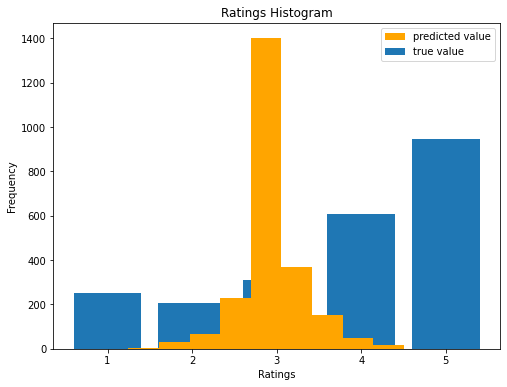

In [133]:
# Plotting the distribution of actual and predicted stars
import matplotlib.pyplot as plt
import seaborn as sns
values, counts = np.unique(df_test['stars'], return_counts=True)

plt.figure(figsize=(8,6))
plt.bar(values, counts, tick_label=['1','2','3','4','5'], label='true value')
plt.hist(predictions, color='orange', label='predicted value')
plt.xlabel("Ratings")
plt.ylabel("Frequency")
plt.title("Ratings Histogram")
plt.legend()
plt.show()

# For 2 Dimensional Embedding space all predictions are just around 3, which gives big error.

Learning Curves

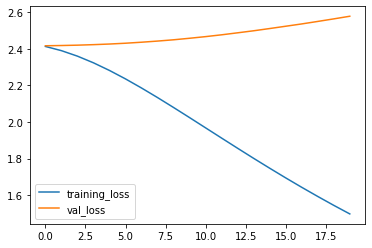

In [134]:
# Learning Curves
df = pd.DataFrame(history.history)

fig = plt.figure()
ax = fig.add_subplot()
ax.plot(df.index, df["loss"], label="training_loss")
ax.plot(df.index, df["val_loss"], label="val_loss")
ax.legend()

# Model is overfitting from the start since validation loss is increasing and training loss keeps decreasing.


Result

Model is overfitting from the start since validation loss is increasing and training loss keeps decreasing.